In [6]:
pip install requests beautifulsoup4 pandas

Note: you may need to restart the kernel to use updated packages.


In [1]:
def fetch_options_data(stock_symbol):
    session = requests.Session()
    
    url = f'https://www.nseindia.com/api/option-chain-indices?symbol={stock_symbol}'
    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36',
        'Accept-Language': 'en-US,en;q=0.9',
        'Referer': 'https://www.nseindia.com/',
        'X-Requested-With': 'XMLHttpRequest',
    }

    response = session.get(url, headers=headers)
    
    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()
        
        # Print the entire response to inspect its structure
        print("Raw response data:", data)  # Print the raw JSON response
        
        if 'records' in data and 'data' in data['records']:
            if len(data['records']['data']) > 0:
                call_data = data['records']['data'][0].get('CE', {})
                put_data = data['records']['data'][0].get('PE', {})
                
                if call_data and put_data:
                    calls_df = pd.DataFrame(call_data)
                    puts_df = pd.DataFrame(put_data)

                    return calls_df, puts_df
                else:
                    print("No call or put data available.")
                    return None, None
            else:
                print("No options data available for the specified symbol.")
                return None, None
        else:
            print("No 'records' or 'data' found in response.")
            return None, None
    else:
        print(f"Failed to retrieve data: {response.status_code} - {response.text}")
        return None, None

# Example usage
calls, puts = fetch_options_data("NIFTY")


NameError: name 'requests' is not defined

In [16]:
import requests
import pandas as pd

def fetch_options_data(stock_symbol):
    session = requests.Session()
    
    url = f'https://www.nseindia.com/api/option-chain-indices?symbol={stock_symbol}'
    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36',
        'Accept-Language': 'en-US,en;q=0.9',
        'Referer': 'https://www.nseindia.com/',
        'X-Requested-With': 'XMLHttpRequest',
    }

    response = session.get(url, headers=headers)
    
    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()
        
        # Print the entire response to inspect its structure
        print("Raw response data:", data)  # Print the raw JSON response
        
        if 'records' in data and 'data' in data['records']:
            if len(data['records']['data']) > 0:
                calls_data = []
                puts_data = []

                # Loop through the data to extract calls and puts
                for option in data['records']['data']:
                    strike_price = option['strikePrice']
                    expiry_date = option['expiryDate']
                    
                    # Check for Call options (CE)
                    if 'CE' in option:
                        calls_data.append({
                            'strikePrice': strike_price,
                            'expiryDate': expiry_date,
                            **option['CE']
                        })
                    
                    # Check for Put options (PE)
                    if 'PE' in option:
                        puts_data.append({
                            'strikePrice': strike_price,
                            'expiryDate': expiry_date,
                            **option['PE']
                        })
                
                # Create DataFrames
                calls_df = pd.DataFrame(calls_data) if calls_data else pd.DataFrame()
                puts_df = pd.DataFrame(puts_data) if puts_data else pd.DataFrame()

                return calls_df, puts_df
            else:
                print("No options data available for the specified symbol.")
                return None, None
        else:
            print("No 'records' or 'data' found in response.")
            return None, None
    else:
        print(f"Failed to retrieve data: {response.status_code} - {response.text}")
        return None, None

# Example usage
calls, puts = fetch_options_data("NIFTY")
print("Calls:")
print(calls[['strikePrice', 'expiryDate', 'impliedVolatility']])
print("Puts:")
print(puts[['strikePrice', 'expiryDate', 'impliedVolatility']])


# Remove zero IV from the DataFrame
filtered_calls = calls[calls['impliedVolatility'] > 0]
filtered_puts = puts[puts['impliedVolatility'] > 0]

Raw response data: {'records': {'expiryDates': ['24-Oct-2024', '31-Oct-2024', '07-Nov-2024', '14-Nov-2024', '21-Nov-2024', '28-Nov-2024', '26-Dec-2024', '27-Mar-2025', '26-Jun-2025', '25-Sep-2025', '24-Dec-2025', '25-Jun-2026', '31-Dec-2026', '24-Jun-2027', '30-Dec-2027', '29-Jun-2028', '28-Dec-2028', '28-Jun-2029'], 'data': [{'strikePrice': 12000, 'expiryDate': '25-Jun-2026', 'PE': {'strikePrice': 12000, 'expiryDate': '25-Jun-2026', 'underlying': 'NIFTY', 'identifier': 'OPTIDXNIFTY25-06-2026PE12000.00', 'openInterest': 20, 'changeinOpenInterest': 0, 'pchangeinOpenInterest': 0, 'totalTradedVolume': 0, 'impliedVolatility': 0, 'lastPrice': 20.1, 'change': 0, 'pChange': 0, 'totalBuyQuantity': 250, 'totalSellQuantity': 0, 'bidQty': 250, 'bidprice': 20.05, 'askQty': 0, 'askPrice': 0, 'underlyingValue': 24854.05}}, {'strikePrice': 12000, 'expiryDate': '31-Dec-2026', 'PE': {'strikePrice': 12000, 'expiryDate': '31-Dec-2026', 'underlying': 'NIFTY', 'identifier': 'OPTIDXNIFTY31-12-2026PE12000.00

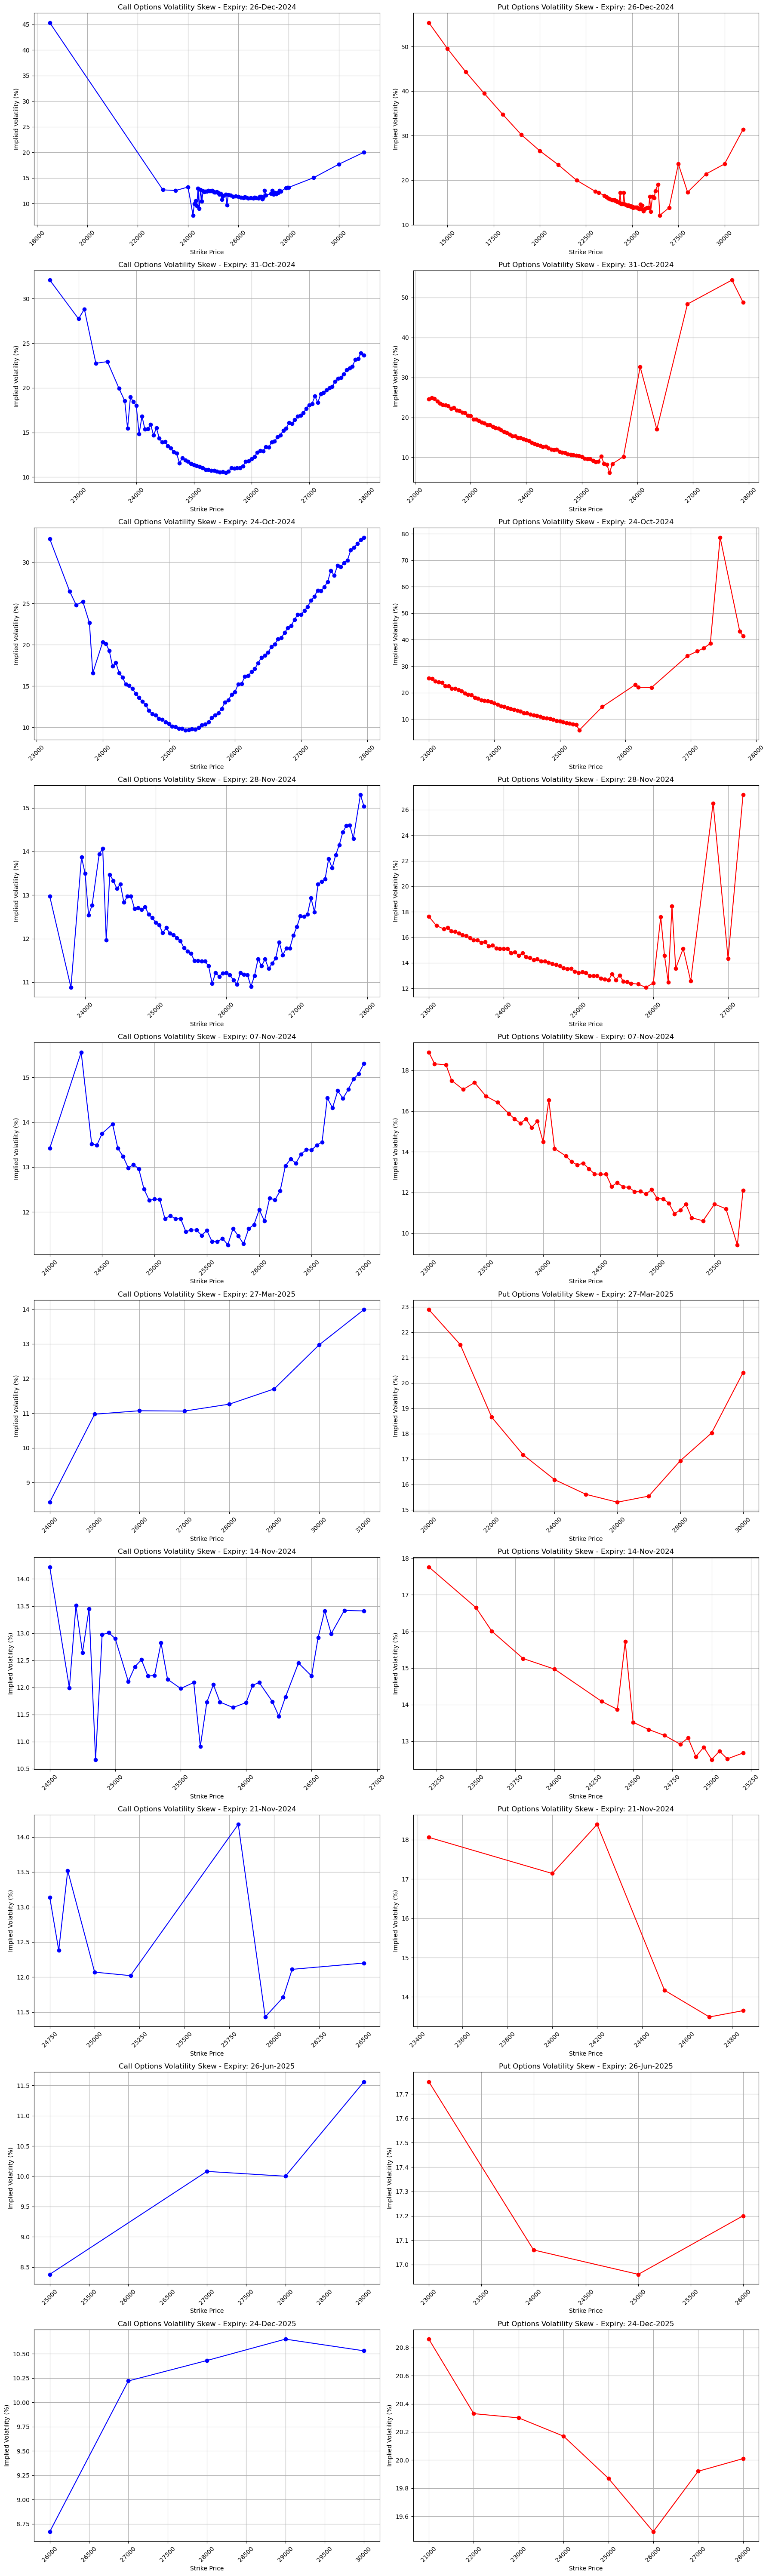

In [18]:
def plot_volatility_skew_by_maturity(calls_df, puts_df):
    # Get unique expiry dates
    expiry_dates = calls_df['expiryDate'].unique()

    # Set up the figure for subplots
    n = len(expiry_dates)
    plt.figure(figsize=(18, 6 * n))  # Adjust size based on number of maturities

    for i, expiry in enumerate(expiry_dates):
        # Filter calls and puts for the current expiry date
        calls_expiry = calls_df[calls_df['expiryDate'] == expiry]
        puts_expiry = puts_df[puts_df['expiryDate'] == expiry]
        
        # Call options subplot
        plt.subplot(n, 2, 2 * i + 1)
        plt.plot(calls_expiry['strikePrice'], calls_expiry['impliedVolatility'], 
                 marker='o', color='blue')
        plt.title(f'Call Options Volatility Skew - Expiry: {expiry}')
        plt.xlabel('Strike Price')
        plt.ylabel('Implied Volatility (%)')
        plt.xticks(rotation=45)
        plt.grid()

        # Put options subplot
        plt.subplot(n, 2, 2 * i + 2)
        plt.plot(puts_expiry['strikePrice'], puts_expiry['impliedVolatility'], 
                 marker='o', color='red')
        plt.title(f'Put Options Volatility Skew - Expiry: {expiry}')
        plt.xlabel('Strike Price')
        plt.ylabel('Implied Volatility (%)')
        plt.xticks(rotation=45)
        plt.grid()

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Example usage with your filtered DataFrames
plot_volatility_skew_by_maturity(filtered_calls, filtered_puts)


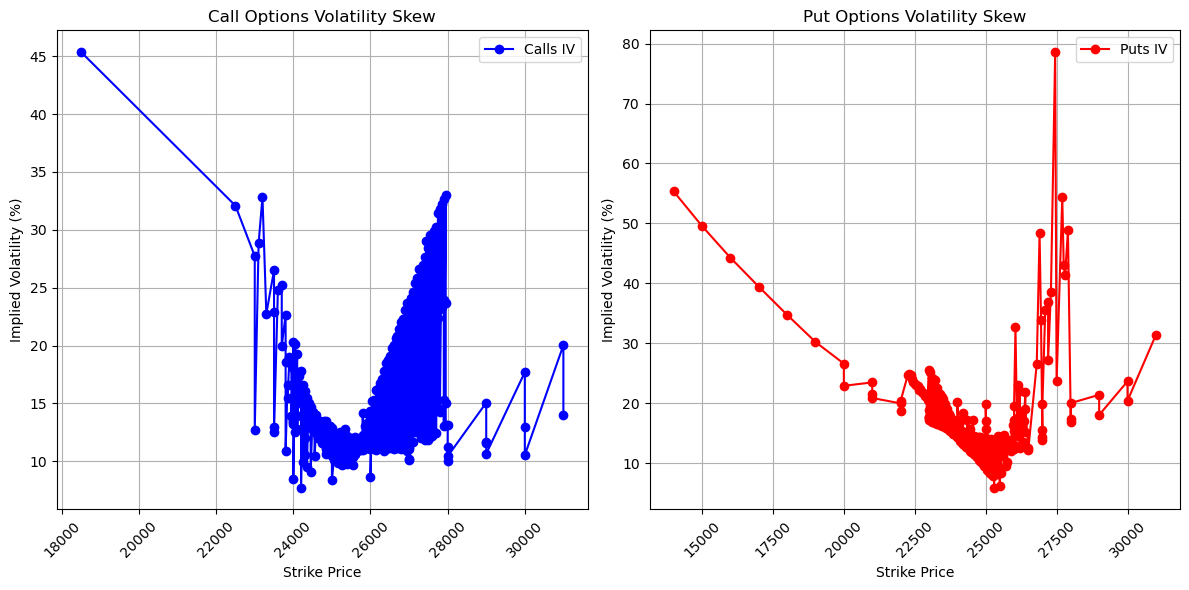

In [12]:
import matplotlib.pyplot as plt

def plot_volatility_skew(calls_df, puts_df):
    # Ensure the DataFrames are already filtered to exclude rows with zero IV

    # Plot for Calls
    plt.figure(figsize=(12, 6))
    
    # Subplot for Calls
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
    plt.plot(calls_df['strikePrice'], calls_df['impliedVolatility'], 
             label='Calls IV', marker='o', color='blue')
    plt.title('Call Options Volatility Skew')
    plt.xlabel('Strike Price')
    plt.ylabel('Implied Volatility (%)')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.grid()
    plt.legend()

    # Subplot for Puts
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
    plt.plot(puts_df['strikePrice'], puts_df['impliedVolatility'], 
             label='Puts IV', marker='o', color='red')
    plt.title('Put Options Volatility Skew')
    plt.xlabel('Strike Price')
    plt.ylabel('Implied Volatility (%)')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.grid()
    plt.legend()
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Example usage with your filtered DataFrames
plot_volatility_skew(filtered_calls, filtered_puts)


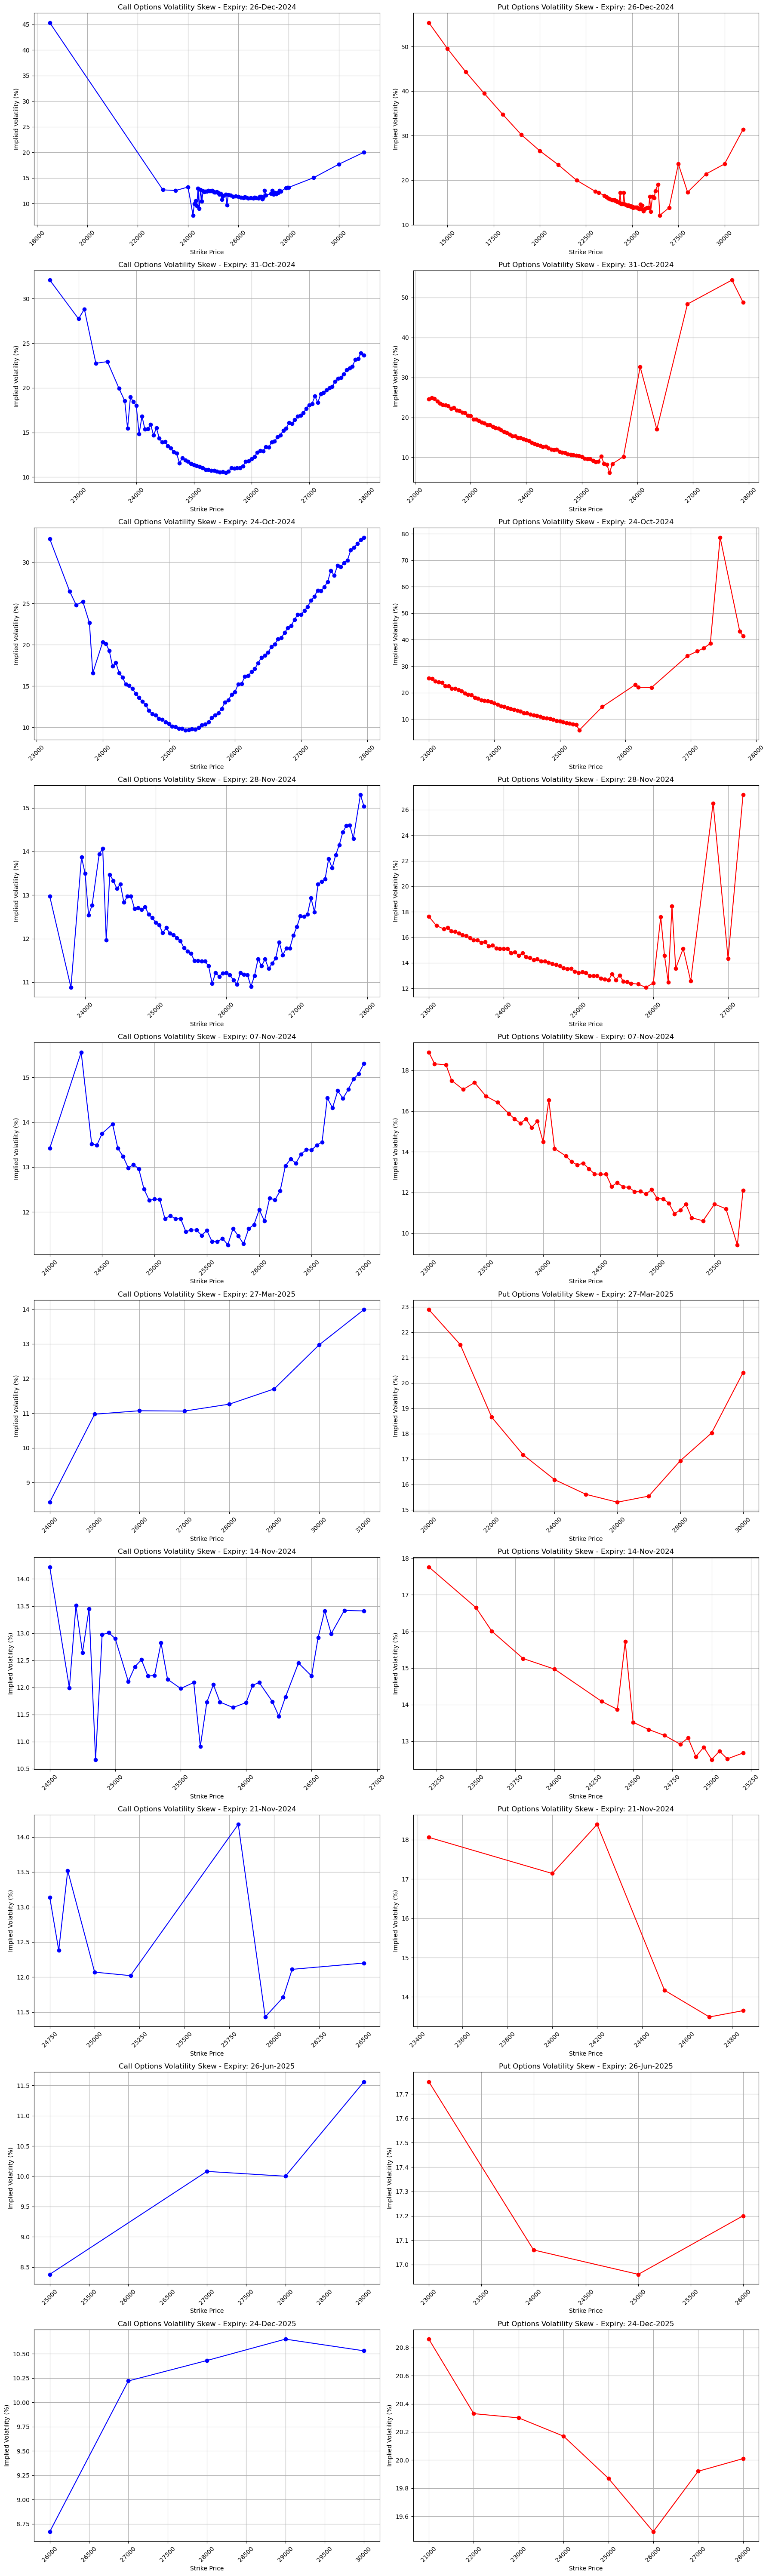

In [13]:
def plot_volatility_skew_by_maturity(calls_df, puts_df):
    # Get unique expiry dates
    expiry_dates = calls_df['expiryDate'].unique()

    # Set up the figure for subplots
    n = len(expiry_dates)
    plt.figure(figsize=(18, 6 * n))  # Adjust size based on number of maturities

    for i, expiry in enumerate(expiry_dates):
        # Filter calls and puts for the current expiry date
        calls_expiry = calls_df[calls_df['expiryDate'] == expiry]
        puts_expiry = puts_df[puts_df['expiryDate'] == expiry]
        
        # Call options subplot
        plt.subplot(n, 2, 2 * i + 1)
        plt.plot(calls_expiry['strikePrice'], calls_expiry['impliedVolatility'], 
                 marker='o', color='blue')
        plt.title(f'Call Options Volatility Skew - Expiry: {expiry}')
        plt.xlabel('Strike Price')
        plt.ylabel('Implied Volatility (%)')
        plt.xticks(rotation=45)
        plt.grid()

        # Put options subplot
        plt.subplot(n, 2, 2 * i + 2)
        plt.plot(puts_expiry['strikePrice'], puts_expiry['impliedVolatility'], 
                 marker='o', color='red')
        plt.title(f'Put Options Volatility Skew - Expiry: {expiry}')
        plt.xlabel('Strike Price')
        plt.ylabel('Implied Volatility (%)')
        plt.xticks(rotation=45)
        plt.grid()

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Example usage with your filtered DataFrames
plot_volatility_skew_by_maturity(filtered_calls, filtered_puts)


In [15]:
filtered_calls.to_clipboard(index=False)